# Step 1

## Get links to scripts

In [1]:
from bs4 import BeautifulSoup
import urllib.request

def fetch(url):
    request = urllib.request.Request(url)
    try:
        read_request = urllib.request.urlopen(request).read()#.decode('utf-8')
        return read_request
    except urllib.error.HTTPError:
        return False
    
def movie_title_from_hyperlink(hyperlink):
    return hyperlink["href"][len(script_link_first_part):-len(script_link_last_part)].replace(":", "")

script_folder_url = 'http://www.imsdb.com/scripts/'
genre_folder_url = 'http://www.imsdb.com/genre/'

script_link_first_part = "/Movie Scripts/"
script_link_last_part = " Script.html"

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Comedy",
    "Drama",
    "Family",
    "Fantasy",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    'Sci-Fi',
    'Thriller',
    "Western"
]

# Number of samples from each genre
samples_from_genres = []

nr_of_recent_comments = 5

# A dictionary with movie title as key. Each movie in the dictionary
# links to a list with all of its genres
movie_dict = dict([])

for i, genre in enumerate(genres):
    
    # Crawl IMSDb for genre
    genre_url = genre_folder_url + genre
    request_text = fetch(genre_url)
    soup = BeautifulSoup(request_text, "html5lib")
    all_hyperlinks = soup.find_all("a", href=True)
    
    found_scripts = 0
    # Get all movies from genre
    for hyperlink in all_hyperlinks:
        if script_link_first_part in hyperlink["href"]: # Check if it is a link to a movie script
            
            found_scripts += 1
            if found_scripts > nr_of_recent_comments:
                
                title = movie_title_from_hyperlink(hyperlink)

                if title not in movie_dict:
                    movie_dict[title] = [0]*len(genres)
                movie_dict[title][i] = 1
    samples_from_genres.append(found_scripts - 5)
    print("nr of movies from", genre, "is", found_scripts - 5)
    
print("Number of links: %d" % ( len(movie_dict) ))
#print(movie_dict)

nr of movies from Action is 326
nr of movies from Adventure is 191
nr of movies from Animation is 40
nr of movies from Comedy is 383
nr of movies from Drama is 628
nr of movies from Family is 51
nr of movies from Fantasy is 128
nr of movies from Horror is 152
nr of movies from Musical is 26
nr of movies from Mystery is 120
nr of movies from Romance is 206
nr of movies from Sci-Fi is 171
nr of movies from Thriller is 400
nr of movies from Western is 17
Number of links: 1167


## Iterate over all links and get scripts

In [32]:
def get_movie_script(movie_title):
    
    script_url = script_folder_url + movie_title.strip(":").replace(" ","-") + ".html"
    request_text = fetch(script_url)
    
    if not request_text: # Check if we got error when attempting to fetch script url
        return ""
    
    soup = BeautifulSoup(request_text, "html5lib")
    
    script = soup.findAll("pre") #
    script_text = ""
    
    if script:
        script_text = script[-1].get_text() # Get all text within most inner "<pre>...</pre>"
    
    return script_text


titles = []
scripts = []
labels = []

for i, movie_title in enumerate(movie_dict.keys()):
    
    script = get_movie_script(movie_title)
    if script != "": # Check if the script was found
        titles.append(movie_title)
        scripts.append(script.replace("\n"," ").replace("\\",""))
        labels.append(movie_dict[movie_title])
    
    if i % 5 == 0: # Just to see progress
        print(i)

scripts_and_labels = {"titles": np.array(titles), "scripts":np.array(scripts), "labels": np.array(labels)}

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165


# Save/Load scripts to file to save time re-crawling

### Save scripts

In [33]:
import pickle
pickle.dump(scripts_and_labels , open( "pickled_scripts_and_labels.p", "wb" ))

### Load scripts

In [2]:
import pickle
scripts_and_labels = pickle.load(open( "pickled_scripts_and_labels.p", "rb" ))

# Step 2

In [5]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stops = set(stopwords.words("english"))

removing collection member with no package: hmm_treebank_pos_tagger
removing collection member with no package: hmm_treebank_pos_tagger
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rasmu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

import os
os.environ["JAVAHOME"] = "C:\\Programming_Languages\\Java\\jre\\bin\\"
nltk.internals.config_java("C:/Programming_Languages/Java/bin/java.exe")
st = StanfordNERTagger('stanford-ner-2017-06-09/classifiers/english.all.3class.distsim.crf.ser.gz',
                       'stanford-ner-2017-06-09/stanford-ner.jar',
                       encoding='utf-8')

text = 'While in France, Karen Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.'

tokenized_text = word_tokenize(text)
classified_text = st.tag(tokenized_text)

print(classified_text)

c:\programming_languages\python352\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


[('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Karen', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')]


## Preprocess all scripts

In [7]:
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np

from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import time
import os

os.environ["JAVAHOME"] = "C:\\Programming_Languages\\Java\\jre\\bin\\"
nltk.internals.config_java("C:/Programming_Languages/Java/bin/java.exe")
st = StanfordNERTagger('stanford-ner-2017-06-09/classifiers/english.all.3class.distsim.crf.ser.gz',
                       'stanford-ner-2017-06-09/stanford-ner.jar',
                       encoding='utf-8')

lmtzr = WordNetLemmatizer()

def preprocess(doc, stops):
    doc = doc.split()

    script_extra_stop_words = {"contd", "ext", "int", "wwwimsdbcom", "script", "continued", "wwwscreentalkorg", "pdf", "imsdb",
                              "int","cont","continued","fran","lynn","marlene","nick","beth","catherine","sid","audrey","willie","indiana","indy","marcus","jack","rachel","jackie","luke","jack","david","michael","anne","digger","sean","rothsam","lynn","william","bob","phil","charlotte","betty","larry","andrew","matt","joe","steve","danny","benedict","evelyn","ellie","trevor","hammond","alan","doug","browning","kate","harvey","charlie","barnes"}
    stops = stops.union(script_extra_stop_words)

    
    classified_text = st.tag(doc)
    
    t1 = time.time()
    new_doc = []
    
    for i, word in enumerate(doc):
        new_word = lmtzr.lemmatize(re.sub(r'\W+', '', word)).replace("/","")
    #    #print(new_word)
    #    #print(st.tag([new_word]))

            
        
        if new_word != "" and new_word.lower() not in stops and i < len(classified_text) and classified_text[i][0] == word.replace("/","") and classified_text[i][1] != "PERSON":
            new_doc.append(new_word.lower())
            
    print(time.time()-t1, "seconds")
    return ' '.join(doc)

preprocessed_scripts = []
for script in scripts_and_labels["scripts"]:
    preprocessed_scripts.append(preprocess(script, stops))
    
preprocessed_scripts = np.array(preprocessed_scripts)
print("Preprocessed all scripts")


c:\programming_languages\python352\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


4.773507595062256 seconds
0.7640330791473389 seconds
0.5223884582519531 seconds
0.4060811996459961 seconds
0.3699500560760498 seconds
0.4201197624206543 seconds
0.6742947101593018 seconds
0.2657051086425781 seconds
0.29979896545410156 seconds
0.26570653915405273 seconds
0.3579530715942383 seconds
0.2596898078918457 seconds
0.3058505058288574 seconds
0.3710017204284668 seconds
0.3559458255767822 seconds
0.4361565113067627 seconds
0.3810141086578369 seconds
0.3419070243835449 seconds
0.49431514739990234 seconds
0.3328847885131836 seconds
0.3288753032684326 seconds
0.3509349822998047 seconds
0.46022868156433105 seconds
0.09224534034729004 seconds
0.36898088455200195 seconds
0.5685102939605713 seconds
0.37950921058654785 seconds
0.7580201625823975 seconds
0.33489084243774414 seconds
0.31784915924072266 seconds
0.36095738410949707 seconds
0.23863458633422852 seconds
0.38355302810668945 seconds
0.30882883071899414 seconds
0.4231276512145996 seconds
0.3920423984527588 seconds
0.31684279441833

0.41410040855407715 seconds
0.2185814380645752 seconds
0.28676533699035645 seconds
0.43916821479797363 seconds
0.8151679039001465 seconds
0.6647686958312988 seconds
0.3785090446472168 seconds
0.3138303756713867 seconds
1.0317432880401611 seconds
0.6587519645690918 seconds
0.37900733947753906 seconds
0.43215036392211914 seconds
0.3940465450286865 seconds
0.5534753799438477 seconds
0.35193562507629395 seconds
0.42813849449157715 seconds
0.26119470596313477 seconds
0.2942824363708496 seconds
0.5043423175811768 seconds
0.30280542373657227 seconds
0.31383514404296875 seconds
0.3058130741119385 seconds
0.28780102729797363 seconds
0.3594553470611572 seconds
0.2917954921722412 seconds
0.24117779731750488 seconds
0.32085275650024414 seconds
0.3188509941101074 seconds
0.1834871768951416 seconds
0.19150972366333008 seconds
0.33388853073120117 seconds
0.28626370429992676 seconds
0.44167399406433105 seconds
0.36898279190063477 seconds
0.314838171005249 seconds
0.4461851119995117 seconds
0.219584465

0.35895490646362305 seconds
0.36898350715637207 seconds
0.14438343048095703 seconds
0.4612259864807129 seconds
0.5996382236480713 seconds
0.40407657623291016 seconds
0.4301443099975586 seconds
0.21056008338928223 seconds
0.4191145896911621 seconds
0.35594654083251953 seconds
0.15540289878845215 seconds
0.3509352207183838 seconds
0.5263998508453369 seconds
0.6196861267089844 seconds
0.4060816764831543 seconds
0.11029338836669922 seconds
0.5690116882324219 seconds
0.3389015197753906 seconds
0.32486677169799805 seconds
0.47727108001708984 seconds
0.523392915725708 seconds
0.30781984329223633 seconds
0.7023699283599854 seconds
0.37299227714538574 seconds
0.2857625484466553 seconds
0.4572155475616455 seconds
0.7941107749938965 seconds
0.0005016326904296875 seconds
0.4430975914001465 seconds
0.4090895652770996 seconds
0.4461851119995117 seconds
1.046783685684204 seconds
0.44267916679382324 seconds
0.48134851455688477 seconds
0.32787442207336426 seconds
0.865302562713623 seconds
0.62867259979

0.29979729652404785 seconds
0.29979419708251953 seconds
0.4512016773223877 seconds
0.31483936309814453 seconds
0.3639791011810303 seconds
0.3689842224121094 seconds
0.4652373790740967 seconds
0.3078186511993408 seconds
0.3469228744506836 seconds
0.5524678230285645 seconds
0.4752662181854248 seconds
0.0 seconds
0.5695149898529053 seconds
0.3148367404937744 seconds
0.31383395195007324 seconds
0.4020366668701172 seconds
0.43465495109558105 seconds
0.31083011627197266 seconds
0.33489489555358887 seconds
0.3820159435272217 seconds
0.28876805305480957 seconds
0.34190917015075684 seconds
0.13536310195922852 seconds
0.5500087738037109 seconds
0.3258662223815918 seconds
0.6617629528045654 seconds
0.5705165863037109 seconds
0.28977155685424805 seconds
0.38000988960266113 seconds
0.43215179443359375 seconds
0.3960850238800049 seconds
0.38602638244628906 seconds
0.4201183319091797 seconds
0.32486629486083984 seconds
0.3429117202758789 seconds
0.4512028694152832 seconds
0.0005013942718505859 second

In [8]:
import pickle
pickle.dump(preprocessed_scripts , open( "pickled_preprocessed_scripts.p", "wb" ))

In [3]:
import pickle
preprocessed_scripts = pickle.load(open( "pickled_preprocessed_scripts.p", "rb" ))

## Compute tfidf

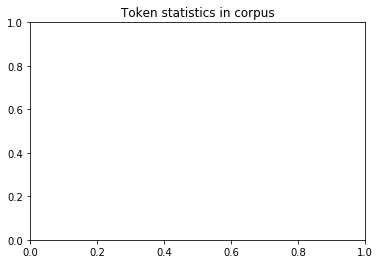

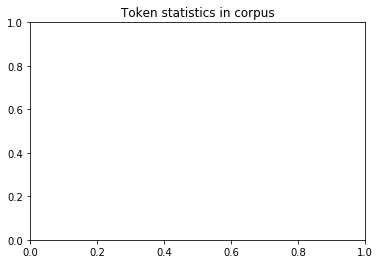

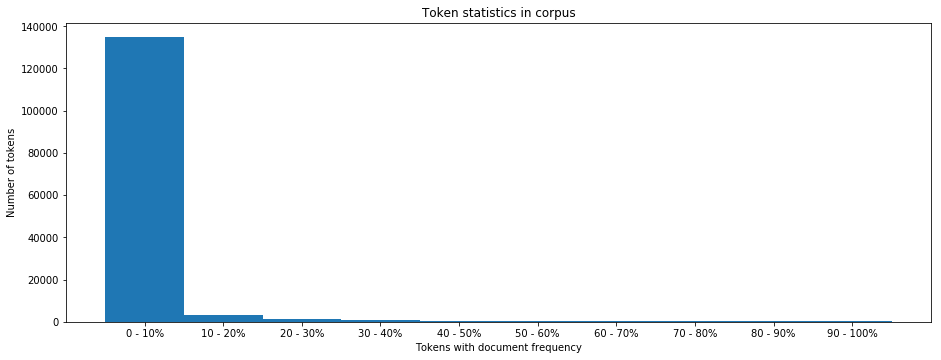

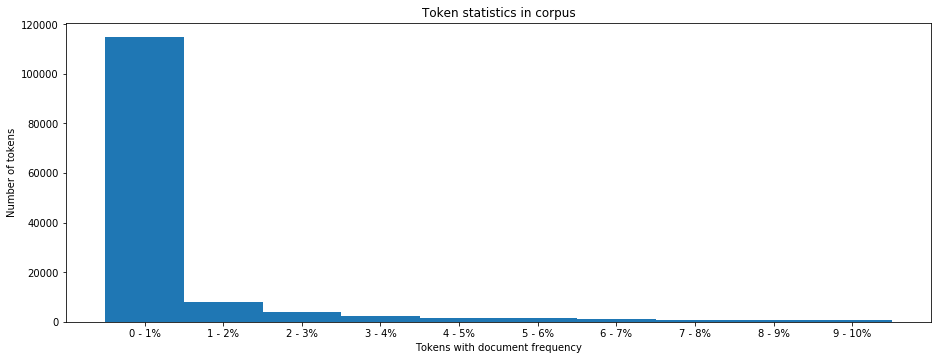

In [192]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

word_in_ranges = []

for word_range in range(1, 11):
    word_range /= 10
    transvector = TfidfVectorizer(stop_words = "english", min_df = word_range - 0.1, max_df = word_range)
    scripts_tfidf = transvector.fit_transform(preprocessed_scripts)
    word_in_ranges.append(len(transvector.idf_))

x = np.arange(10)

fig, ax = plt.subplots()
plt.title('Token statistics in corpus')
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, word_in_ranges, width=1)
plt.xticks(x, [str(w-10) + " - " + str(w) + "%" for w in range(10,110,10)])
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of tokens')
ax.set_xlabel('Tokens with document frequency')
plt.show()

zoomed_word_in_ranges = []

for word_range in range(1, 11):
    word_range /= 100
    transvector = TfidfVectorizer(stop_words = "english", min_df = word_range - 0.01, max_df = word_range)
    scripts_tfidf = transvector.fit_transform(preprocessed_scripts)
    zoomed_word_in_ranges.append(len(transvector.idf_))

x = np.arange(10)

fig, ax = plt.subplots()
plt.title('Token statistics in corpus')
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, zoomed_word_in_ranges, width=1)
plt.xticks(x, [str(w-1) + " - " + str(w) + "%" for w in range(1,11,1)])
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of tokens')
ax.set_xlabel('Tokens with document frequency')
plt.show()



In [235]:
transvector = TfidfVectorizer(stop_words = "english", min_df = 0.06, max_df = 0.5)

#transvector = TfidfVectorizer(stop_words = "english", min_df = 0.03, max_df = 0.3)

scripts_tfidf = transvector.fit_transform(preprocessed_scripts)

vocab = dict([[v,k] for k,v in transvector.vocabulary_.items()])

#print(scripts_tfidf)

print(scripts_tfidf.shape)
print(len(transvector.idf_))

#scores = zip(transvector.get_feature_names(), np.asarray(scripts_tfidf.sum(axis=0)).ravel())
#sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
#for item in sorted_scores:
#    print("{0:50} Score: {1}".format(item[0], item[1]))

(1119, 8498)
8498


# Split into training and test

In [236]:
import numpy as np
# Shuffle the scripts_tfidf and labels together
rng = np.random.seed(None)
p = np.random.permutation(scripts_tfidf.shape[0])
scripts_tfidf = scripts_tfidf[p]
labels = np.array(scripts_and_labels["labels"])[p]
movie_names = np.array(scripts_and_labels["titles"])[p]

print(len(scripts_and_labels["labels"]))
print(len(preprocessed_scripts))
cut_point = int(scripts_tfidf.shape[0]/2) # split 50-50 train test

x_train = scripts_tfidf[:cut_point]
y_train = labels[:cut_point]
titles_train = movie_names[:cut_point]
#y_train = np.array(scripts_and_labels["labels"][:cut_point])

x_test = scripts_tfidf[cut_point:]
y_test = labels[cut_point:]
titles_test = movie_names[cut_point:]
#y_test =  np.array(scripts_and_labels["labels"][cut_point:])

print("Successfully split data into training and test")


1119
1119
Successfully split data into training and test


# Training a classifier

In [238]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score


from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance, ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


#classifier = tree.DecisionTreeClassifier()
#classifier = tree.ExtraTreeClassifier() 
#classifier = ensemble.ExtraTreesClassifier(n_estimators=5) 
#classifier = ensemble.RandomForestClassifier(n_estimators=100)
#classifier = KNeighborsClassifier(n_neighbors=3) #
classifier = MLPClassifier(solver='lbfgs', alpha=1e-5)#, random_state=42)

classifier.fit(x_train, y_train)

preds = classifier.predict(x_test)

pred_distr = preds.sum(axis=0,  dtype='int')
y_test_distr = y_test.sum(axis=0,  dtype='int')

# Since some models sometimes fail to predict any genre, we use a
# secondary classifier to classify every movie without any predicted genres
secondary_classifier = tree.DecisionTreeClassifier()
secondary_classifier.fit(x_train, y_train)

for x in range(len(preds)):
    if sum(preds[x]) == 0:
        preds[x] = secondary_classifier.predict(x_test[x])[0]

accuracy = accuracy_score(y_test,preds)
print("my accuracy is:", accuracy)

flattened_accuracy = accuracy_score(y_test.flatten(),preds.flatten())
print("my flattened accuracy is:", flattened_accuracy)


my accuracy is: 0.105357142857
my flattened accuracy is: 0.831887755102


## Print correctly predicted movies

In [239]:
def print_prediction_genres(pred_array):
    print([genre for index, genre in enumerate(genres) if list(pred_array)[index] == 1])

def pred_equal_ytest(x):
    """x is the predictions index"""
    return sum([1 for y in range(len(preds[x])) if int(preds[x,y]) == int(y_test[x,y])]) == len(genres)

for x in range(len(preds)):
    
    if sum(preds[x]) == 0:
        print("Found script without any predicted genres:", preds[x])
        
    if pred_equal_ytest(x):
    #if not pred_equal_ytest(x):
        print(titles_test[x], end=" - ")
        print_prediction_genres(preds[x])


Black Snake Moan - ['Drama']
All the President's Men - ['Drama', 'Thriller']
Speed - ['Action', 'Thriller']
Dog Day Afternoon - ['Comedy', 'Drama', 'Thriller']
Star Wars Attack of the Clones - ['Action', 'Adventure', 'Fantasy', 'Sci-Fi']
Kundun - ['Drama']
Birdman - ['Comedy', 'Drama', 'Romance']
American Splendor - ['Comedy', 'Drama']
Halloween The Curse of Michael Myers - ['Horror', 'Thriller']
Batman - ['Action', 'Fantasy', 'Thriller']
Get on Up - ['Drama']
TRON Legacy - ['Action', 'Adventure', 'Sci-Fi']
Elephant Man, The - ['Drama']
Boogie Nights - ['Drama']
Pariah - ['Drama']
Confidence - ['Drama']
A Serious Man - ['Comedy']
Pretty Woman (final script) - ['Comedy', 'Romance']
Revolutionary Road - ['Drama', 'Romance']
Storytelling - ['Comedy', 'Drama']
Sling Blade - ['Drama']
Swingers - ['Comedy', 'Drama']
Invictus - ['Drama']
You Can Count On Me - ['Drama']
Star Trek Generations - ['Action', 'Adventure', 'Sci-Fi']
Purple Rain - ['Drama']
Apocalypse Now - ['Action', 'Drama']
12 Yea

## Genre distributions

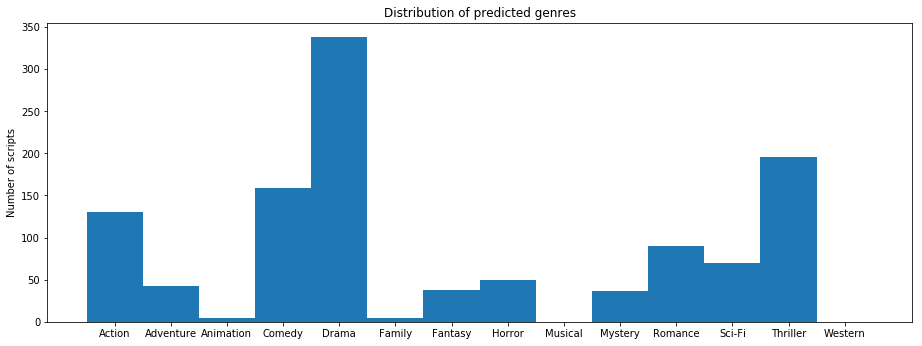

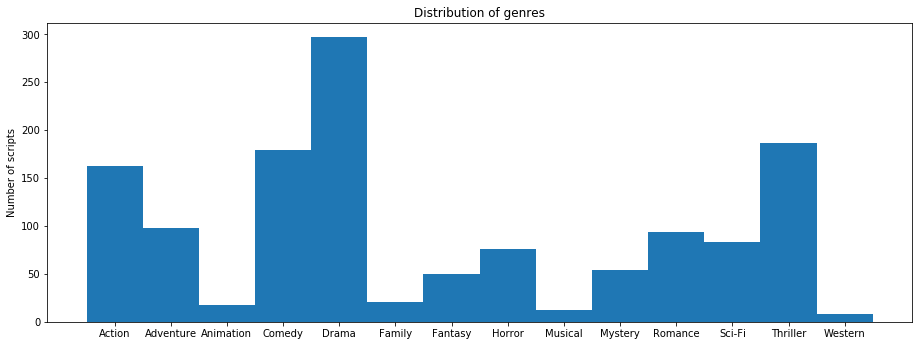

In [240]:
x = np.arange(len(genres))

fig, ax = plt.subplots()
plt.title('Distribution of predicted genres')
#ax.yaxis.set_major_formatter(formatter)
plt.bar(x, pred_distr, width=1)
plt.xticks(x, genres)
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of scripts')
plt.show()


fig, ax = plt.subplots()
plt.title('Distribution of genres')
plt.bar(x, y_test_distr, width=1)
plt.xticks(x, genres)
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of scripts')
plt.show()

## Accuracy per amount of script genres

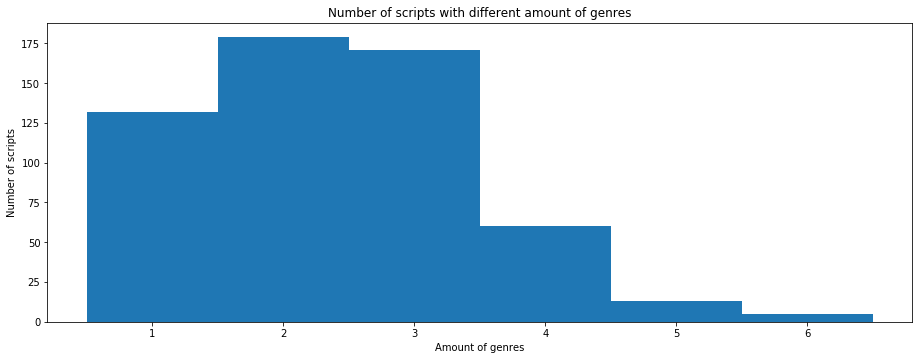

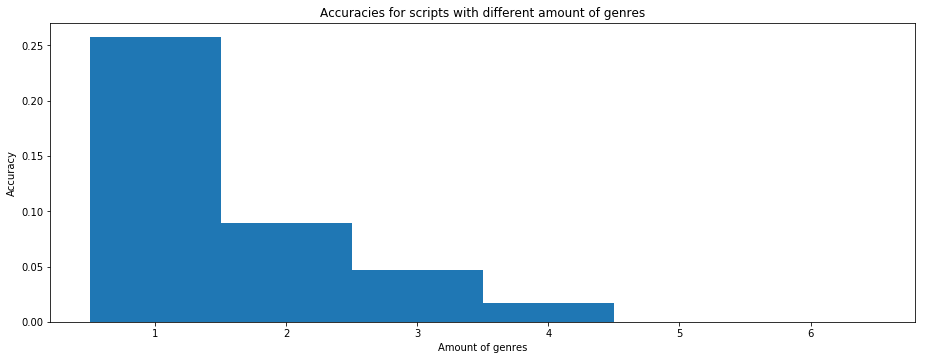

In [243]:
## Proportion of correct predictions

max_nr_of_genres = len(genres)
correct_preds_per_nr_of_genres = [0] * max_nr_of_genres
scripts_per_nr_of_genres = [0] * max_nr_of_genres

for x in range(len(preds)):
    
    if pred_equal_ytest(x):
        correct_preds_per_nr_of_genres[sum(preds[x])] += 1
    scripts_per_nr_of_genres[sum(y_test[x])] += 1

accuracy_per_nr_of_genres = [x/y for x,y in zip(correct_preds_per_nr_of_genres, scripts_per_nr_of_genres) if y != 0]



x = np.arange(len(accuracy_per_nr_of_genres))

# Plot number of scripts per amount of genres
fig, ax = plt.subplots()
plt.title('Number of scripts with different amount of genres')
plt.bar(x, scripts_per_nr_of_genres[1: len(accuracy_per_nr_of_genres)+1], width=1)
plt.xticks(x, range(1, len(accuracy_per_nr_of_genres)+1))
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Number of scripts')
ax.set_xlabel('Amount of genres')
plt.show()

# Plot accuracy per amount of genres
fig, ax = plt.subplots()
plt.title('Accuracies for scripts with different amount of genres')
plt.bar(x, accuracy_per_nr_of_genres, width=1)
plt.xticks(x, range(1, len(accuracy_per_nr_of_genres)+1))
fig.set_size_inches(15.5, 5.5)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Amount of genres')
plt.show()

In [149]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from time import time

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        #print("Topic #%d:" % topic_idx)
        print(",".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]), end="")
    print()

n_top_words = 5

t0 = time()
nmf = NMF(n_components=len(genres), random_state=1,
          alpha=.1, l1_ratio=.5).fit(scripts_tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = transvector.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

lda = LatentDirichletAllocation(n_topics=len(genres), max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(scripts_tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = transvector.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

done in 6.255s.

Topics in NMF model:
continued,rev,07,bobby,omitteddr,mike,peter,billy,maryscript,database,com,internet,posterssam,annie,chris,merry,georgejack,elizabeth,danny,victoria,bunnyharry,helen,diego,thomas,tedpaul,annie,ruth,scott,laserfrank,larry,joe,april,rachelnick,alex,carol,raymond,loumax,betty,eddie,jackie,henrycharlie,tony,edward,goose,eddiedavid,alex,elizabeth,steve,09ben,jelly,robinson,sandy,annasarah,carter,1000,mary,kelly


c:\programming_languages\python352\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


done in 14.210s.

Topics in LDA model:
max,jimmy,dave,ann,benle,la,et,il,lesscript,database,com,internet,postersbobby,james,charlie,helen,lucysarah,chris,ted,continued,arthurcontinued,sam,frank,alex,bencontinued,jack,sam,charlie,drgeorge,olive,continued,rose,robinpaul,edward,anna,rick,mossadam,peter,parker,susan,simonharry,andy,phil,alike,karenjack,david,sam,willie,rayjoe,bob,duke,jake,jayeric,ann,rachel,mike,jake


## Using one multinomial classifier for each genre
When using one separate multinomial classifier for each genre, we end up with solely drama predictions, resulting in 12.6% accuracy. This is the highest achieved accuracy; however, it is not satisfying. Furthermore, this proves that accuracy might not be the best measure in this case. After all, I would rather have `[Action, Thriller, Adventure]` than `[Drama]` when the true answer is `[Action, Thriller, Adventure, Drama]`. When using simple accuracy as a measure of success, the model's potential complexity is somewhat hidden.

In [152]:
final_preds = []

for genre_index in range(len(genres)):
    genre_y_train = np.array([x[genre_index] for x in y_train])#.reshape(-1, 1)
    genre_y_test = np.array([x[genre_index] for x in y_test])#.reshape(-1, 1)

    classifier = MultinomialNB()
    #classifier = svm.SVC()
    #classifier = linear_model.SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None) #82% tot acc
    #classifier = KNeighborsClassifier(n_neighbors=3)
    #classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 2), random_state=42)
    #classifier = tree.DecisionTreeClassifier(min_samples_leaf = 3)
    #classifier = AdaBoostClassifier(n_estimators=10)
                        
    classifier.fit(x_train, genre_y_train)
    pred = classifier.predict(x_test)                        
    accuracy = accuracy_score(genre_y_test,pred)
    

    print("Genre:", genres[genre_index])
    print("Accuracy:", accuracy)
    print("Samples in genre:", samples_from_genres[genre_index])   
    print("")
    
    if genre_index == 0:
        final_preds = [[pred[x]] for x in range(len(genre_y_test))]
    else:
        for i in range(len(pred)):
            final_preds[i].append(pred[i])
            

correct = 0

for x in range(len(final_preds)):
    if sum([1 for y in range(len(final_preds[x])) if int(final_preds[x][y]) == int(y_test[x][y])]) == len(genres):
        correct += 1
        print(titles_test[x], end=" - ")
        print_prediction_genres(final_preds[x])
        
print("Accuracy:", correct/len(final_preds))

Genre: Action
Accuracy: 0.717857142857
Samples in genre: 326

Genre: Adventure
Accuracy: 0.833928571429
Samples in genre: 191

Genre: Animation
Accuracy: 0.960714285714
Samples in genre: 40

Genre: Comedy
Accuracy: 0.678571428571
Samples in genre: 383

Genre: Drama
Accuracy: 0.605357142857
Samples in genre: 628

Genre: Family
Accuracy: 0.95
Samples in genre: 51

Genre: Fantasy
Accuracy: 0.9
Samples in genre: 128

Genre: Horror
Accuracy: 0.839285714286
Samples in genre: 152

Genre: Musical
Accuracy: 0.973214285714
Samples in genre: 26

Genre: Mystery
Accuracy: 0.907142857143
Samples in genre: 120

Genre: Romance
Accuracy: 0.823214285714
Samples in genre: 206

Genre: Sci-Fi
Accuracy: 0.844642857143
Samples in genre: 171

Genre: Thriller
Accuracy: 0.653571428571
Samples in genre: 400

Genre: Western
Accuracy: 0.991071428571
Samples in genre: 17

An Education - ['Drama']
Dead Poets Society - ['Drama']
Woodsman, The - ['Drama']
Confessions of a Dangerous Mind - ['Drama']
Believer, The - ['D

In [75]:
for x in range(len(final_preds)):
    #if np.array_equal(preds[x],y_test[x]):
    if sum([1 for y in range(len(final_preds[x])) if int(final_preds[x][y]) == int(y_test[x][y])]) == len(genres):
        
        print(titles_test[x], end=" - ")
        print_prediction_genres(final_preds[x])

Artist, The - ['Comedy', 'Drama', 'Romance']
Awakenings - ['Drama']
Philadelphia - ['Drama']
Rebel Without A Cause - ['Drama']
Henry's Crime - ['Drama']
Donnie Brasco - ['Drama', 'Thriller']
